## Seq2Seq(GRU)

### 資料讀取

In [1]:
from pandas import read_csv
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### 資料預處理

In [2]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [0]:
from sklearn.preprocessing import LabelEncoder
values = dataset.values
encoder = LabelEncoder()
wnd_dir = encoder.fit_transform(values[:,4])

In [0]:
dataset['wnd_dir'] = wnd_dir

In [5]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [0]:
from sklearn.preprocessing import StandardScaler

def df_to_lstm_format(df, test_size=0.5, look_back=5, target_column='target', scale_X=True):

    df = df.copy()

    # 最後一個欄位為預測目標
    df['target'] = df[target_column] 
    # 捨棄 y
    df = df.drop(columns=[target_column]) 
    
    # 取得目標 y
    target_location = df.shape[1] - 1 
    
    # 根據 test_size 比例分割資料
    split_index = int(df.shape[0]*test_size) 
    
    # 訓練資料集
    X_train = df.values[:split_index, :target_location]
    y_train = df.values[:split_index, target_location]

    # 測試資料集
    X_test = df.values[split_index:, :target_location] 
    y_test = df.values[split_index:, target_location] 

    # 將資料正規化 (如果 scale_X 為True)
    if scale_X:
        scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
        X_train = scalerX.transform(X_train)
        X_test = scalerX.transform(X_test)
        
    # 重塑輸入矩陣
    samples = len(X_train) 
    num_features = target_location 

    samples_train = X_train.shape[0] - look_back
    
    # 重塑訓練資料
    # (資料筆數, 往前看多少筆, 特徵數量)
    X_train_reshaped = np.zeros((samples_train, look_back, num_features))
    y_train_reshaped = np.zeros((samples_train))

    
    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]

    # 重塑測試資料
    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        y_test_reshaped[i] = y_test[y_position]
    
    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

### 將資料轉換為 LSTM(GRU) 需要的格式

In [0]:
import numpy as np
look_back = 24
test_size = 0.5


X_train, y_train, X_test, y_test = df_to_lstm_format(df=dataset, 
                                                     test_size=test_size, 
                                                     look_back=look_back, 
                                                     target_column='pollution', scale_X=True)

In [0]:
# 建立編碼器與解碼器所需numpy array
encoder_input_train = X_train
decoder_input_train = np.zeros((X_train.shape[0], X_train.shape[1], 1)) # Zeros array
decoder_output_train = y_train.reshape((y_train.shape[0], 1, 1))

encoder_input_test = X_test
decoder_input_test = np.zeros((X_test.shape[0], X_test.shape[1], 1)) # Zeros array
decoder_output_test = y_test.reshape((y_test.shape[0], 1, 1))

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21876, 24, 7), (21876,), (21876, 24, 7), (21876,))

## 建立 Seq2Seq (GRU) 模型

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

### 編碼器 (Encoder)

In [0]:
num_features = dataset.shape[1] - 1
layers = [50,50,]

# 定義輸入序列
encoder_inputs = tf.keras.layers.Input(shape=(None, num_features))


# 建立 Encoder
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(tf.keras.layers.GRUCell(hidden_neurons,
                                              kernel_initializer='TruncatedNormal'))

encoder = tf.keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# 只保留狀態，不保留輸出
encoder_states = encoder_outputs_and_states[1:]

### 解碼器 (GRU)

In [0]:
output_dim = 1

decoder_inputs = tf.keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(tf.keras.layers.GRUCell(hidden_neurons,
                                             kernel_initializer='TruncatedNormal'))

decoder = tf.keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# 將encoder 的輸出設定為decoder 起始狀態
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# 只取得output，不用 state
decoder_outputs = decoder_outputs_and_states[0]

# 產生預測結果
decoder_dense = tf.keras.layers.Dense(output_dim,
                                   activation='linear')

decoder_outputs = decoder_dense(decoder_outputs)

### 建立 Cost Function

In [18]:
import keras.backend as K
def mape(y_true, y_pred):
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

Using TensorFlow backend.


### 編譯模型

In [0]:
model = tf.keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer='adam', loss='mse', metrics=[mape, smape])

In [20]:
from time import time
epochs = 10
model.fit([encoder_input_train, decoder_input_train], decoder_output_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_output_test), 
          epochs=epochs, verbose=1)



Epoch 1/10
684/684 [==============================] - ETA: 0s - loss: 13055.9551 - mape: 7181670.5000 - smape: 54.3320

KeyboardInterrupt: ignored

In [21]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
rnn_1 (RNN)                     [(None, 50), (None,  24150       input_2[0][0]                    
__________________________________________________________________________________________________
rnn_2 (RNN)                     [(None, None, 50), ( 23250       input_3[0][0]                    
                                                                 rnn_1[0][1]                  

### 產生預測結果

In [0]:
encoder_predict_model = tf.keras.models.Model(encoder_inputs,
                                           encoder_states)

decoder_states_inputs = []

for hidden_neurons in layers[::-1]:
    decoder_states_inputs.append(tf.keras.layers.Input(shape=(hidden_neurons,)))

decoder_outputs_and_states = decoder(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs = decoder_outputs_and_states[0]
decoder_states = decoder_outputs_and_states[1:]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_predict_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)

In [0]:
def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    y_predicted = []

    # 將輸入值轉變為狀態向量
    states = encoder_predict_model.predict(x)

    # 狀態向量必須是 list
    if not isinstance(states, list):
        states = [states]

    # 產生第一筆解碼值
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # 增加預測結果
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

In [25]:
# 每次只預測下一筆
num_steps_to_predict = 1
batch_size = 1

y_preds= predict(X_test, encoder_predict_model, decoder_predict_model, num_steps_to_predict)
y_preds = y_preds.reshape(y_preds.shape[0])
y_preds.shape

(21876,)

In [26]:
y_true = y_test.reshape(y_test.shape[0])
y_true.shape

(21876,)

In [0]:
split_index = int(dataset.shape[0]*test_size)
x = dataset[split_index:]

In [28]:
datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # 修正延遲數
x.index.shape

(21876,)

### 評估預測結果

684/684 [==============================] - 20s 30ms/step - loss: 11460.9746 - mape: 165.9850 - smape: 42.6914


Text(0.5, 1.0, 'Seq2Seq \n MSE = 11460.97 \n MAPE = 166.0 [%] \n SMAPE = 42.7 [%]')

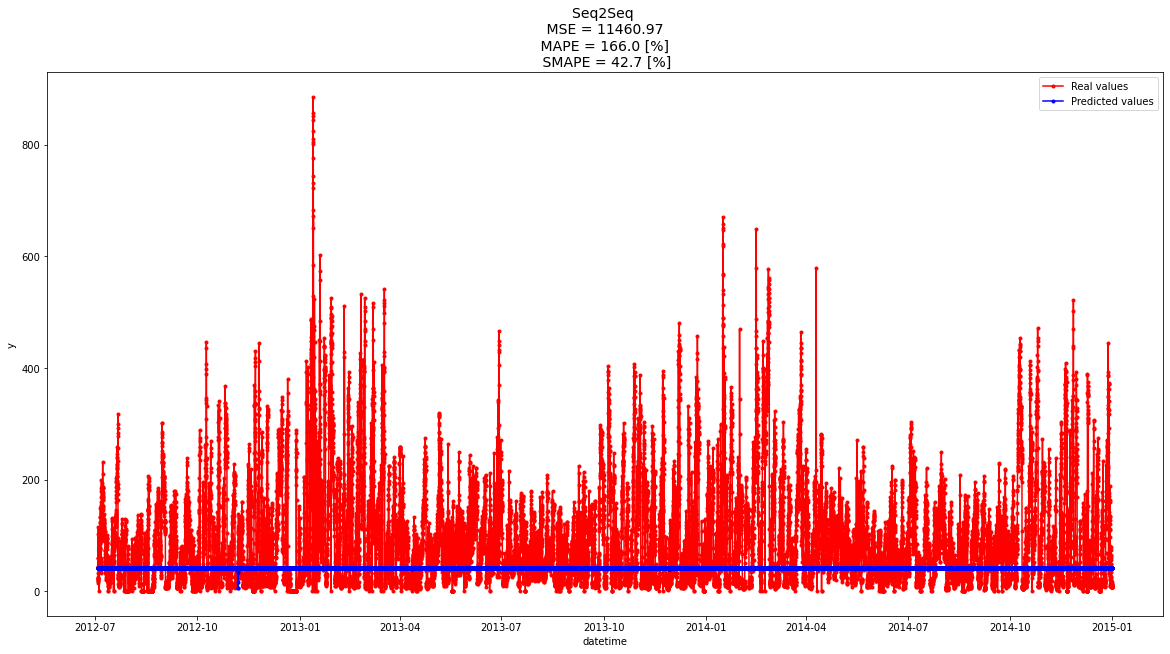

In [29]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values')
plt.plot(x.index, y_preds, '.-', color='blue', label='Predicted values')

plt.ylabel('y')
plt.xlabel('datetime')
plt.legend()

mse = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[0]
mape = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[1]
smape = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[2]

plt.title('Seq2Seq \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse, mape, smape), fontsize = 14)

### 考量時間因素

In [30]:
dataset = read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [0]:
import pandas
hour_data = pandas.get_dummies(dataset.index.hour)

In [40]:
len(hour_data)

43824

In [0]:
hour_data.index = dataset.index

In [45]:
hour_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
year_month_day_hour,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:00:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:00:00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-01 03:00:00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-01 04:00:00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
len(dataset)

43824

In [47]:
pandas.concat([dataset, hour_data], axis = 1).head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
year_month_day_hour,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
